# File Ingestion

## Setup

Using local config file (see [01_pipeline](./01_pipeline.ipynb))

In [1]:
# import os
# import datajoint as dj;
# # change to the upper level folder to detect dj_local_conf.json
# if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
# assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
# from adamacs.pipeline import subject, behavior, session, event, trial

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()
from adamacs.pipeline import subject, behavior, session, event, trial
from adamacs.ingest import behavior as ibe


[2023-07-23 15:10:43,539][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-07-23 15:10:43,585][INFO]: Connected tobiasr@172.26.128.53:3306


Manual entry

### BPod Path Setup

Your `dj.config` file should have a section for your BPod root directory under `custom`: `exp_root_data_dir`. This is a list of one or more paths where the ingestion tool will look for the relative paths it is given.

In [2]:
import datajoint as dj
from element_interface.utils import find_full_path
from adamacs.pipeline import session, event, trial
from adamacs.ingest.bpod import Bpodfile
from adamacs.paths import get_experiment_root_data_dir

bpod_path = "DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat"
# bpod_path = "TR_WEZ-8701_2023-01-13_scan9FG1THFD_sess9FG1TAXY/scan9FG1THFD_WEZ-8701_StimArenaMaster_20230113_172307.mat"

root_dirs = dj.config["custom"]["exp_root_data_dir"]
bpod_path_full = find_full_path(get_experiment_root_data_dir(),bpod_path)

print(f"Root: {root_dirs}\nFull: {bpod_path_full}")

Root: ['/datajoint-data/data/tobiasr']
Full: /datajoint-data/data/tobiasr/DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat


### Initial check of tables

In [3]:
# from adamacs.pipeline import session, event, trial

# session.Session.delete()


# print('Sessions:', len(session.Session()))
# print('Trials  :', len(trial.Trial()))
# print('Events  :', len(event.Event()))

In [4]:
# event.EventType.delete()

In [5]:
event.BehaviorRecording()

session_id,scan_id,recording_start_time,recording_duration,recording_notes
sess9FB2LN5C,scan9FB2LN5C,2022-03-18 16:55:28,288.667,BPod version: 2.0
sess9FJ5PTCQ,scan9FJ5PTCQ,2023-07-20 16:01:50,320.0,


In [6]:
dj.Diagram(behavior)+dj.Diagram(event)+dj.Diagram(trial)

ValueError: Node names and attributes should not contain ":" unless they are quoted with "".                    For example the string 'attribute:data1' should be written as '"attribute:data1"'.                    Please refer https://github.com/pydot/pydot/issues/258

## Automated BPod ingestion

The function is designed ask for a confirmation before entered into the schema.

In [ ]:
session.Session()

session_id,subject PyRat import uses this for earmark value,session_datetime
sess9FB2LN5C,WEZ-8701,2022-03-18 00:00:00
sess9FI8ETDQ,ROS-1518,2023-05-25 00:00:00
sess9FJ4IJOQ,ROS-1518,2023-07-18 00:00:00
sess9FJ5PTCQ,OPI-1681,2023-07-20 00:00:00


In [ ]:
bpod_path = "DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat"
root_dirs = dj.config["custom"]["exp_root_data_dir"]
bpod_object = Bpodfile(bpod_path)




In [7]:
bpod_object.ingest('sess9FB2LN5C', 'scan9FB2LN5C')

NameError: name 'bpod_object' is not defined

In [ ]:
event.Event()

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FB2LN5C,scan9FB2LN5C,at_port,39.5742,nan
sess9FB2LN5C,scan9FB2LN5C,at_port,45.72,nan
sess9FB2LN5C,scan9FB2LN5C,at_port,97.7857,nan
sess9FB2LN5C,scan9FB2LN5C,at_port,175.701,nan
sess9FB2LN5C,scan9FB2LN5C,at_port,273.0,nan
sess9FB2LN5C,scan9FB2LN5C,at_target,16.9692,nan
sess9FB2LN5C,scan9FB2LN5C,at_target,33.7099,nan
sess9FB2LN5C,scan9FB2LN5C,at_target,76.791,nan
sess9FB2LN5C,scan9FB2LN5C,at_target,150.778,nan
sess9FB2LN5C,scan9FB2LN5C,at_target,290.64,nan


In [ ]:
scansi = "scan9FJ5PTCQ"
(event.Event & f'scan_id = "{scansi}"')

session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,31.983,32.083
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,63.5972,63.6972
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,92.1419,92.2419
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,110.971,111.071
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,125.036,125.136
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,137.26,137.36
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,152.14,152.24
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,169.614,169.714
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,184.736,184.837
sess9FJ5PTCQ,scan9FJ5PTCQ,aux_bpod_reward,218.035,218.135


In [8]:
(trial.TrialEvent & f'scan_id = "{scansi}"' & "trial_id = 1").fetch(format = "frame", order_by = "event_start_time")

NameError: name 'scansi' is not defined

Check that insertion worked:

In [9]:
trial.TrialEvent & 'trial_id=0'

session_id,scan_id,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start
sess9FB2LN5C,scan9FB2LN5C,0,at_port,45.72
sess9FB2LN5C,scan9FB2LN5C,0,at_target,16.9692
sess9FB2LN5C,scan9FB2LN5C,0,cue,16.9592
sess9FB2LN5C,scan9FB2LN5C,0,reward,22.8689
sess9FB2LN5C,scan9FB2LN5C,0,reward,45.82


In [10]:
event.EventType()

event_type,event_type_description
Amplitude_Ramp;Full_Field_Chirp;0;0;360;0;0;0;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-10;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-11;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-12;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-13;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-14;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-15;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-16;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-17;15;20:50;0;0;3;,
Appearing_Checkerboard_Noise:0;Appearing_Checkerboard_Noise;-18;15;20:50;0;0;3;,


We can also interact with bpod objects. For example:

In [11]:
bpod_object.trial(2).events

NameError: name 'bpod_object' is not defined

In [12]:
bpod_object.trial(2).attributes

NameError: name 'bpod_object' is not defined

In [13]:
bpod_object.trial_data

NameError: name 'bpod_object' is not defined

# Add Harp recording

In [14]:
from adamacs.pipeline import behavior, event, scan
from adamacs.ingest.harp import HarpLoader
event_recording = event.BehaviorRecording.fetch('KEY')[0]
behavior.HarpRecording()

session_id,scan_id,harp_device_id
sess9FB2LN5C,scan9FB2LN5C,1


In [15]:
event.BehaviorRecording()

session_id,scan_id,recording_start_time,recording_duration,recording_notes
sess9FB2LN5C,scan9FB2LN5C,2022-03-18 16:55:28,288.667,BPod version: 2.0
sess9FJ5PTCQ,scan9FJ5PTCQ,2023-07-20 16:01:50,320.0,


In [16]:
event_recording

{'session_id': 'sess9FB2LN5C', 'scan_id': 'scan9FB2LN5C'}

In [17]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
harp_paths = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*harp*bin"))

In [18]:
scansi = "scan9FJ5PTCQ"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]

bpod_path_relative = (event.BehaviorRecording.File & scan_key).fetch1("filepath")
harp_paths = list(find_full_path(
    get_experiment_root_data_dir(), bpod_path_relative
).parent.glob("*IMU_harp*csv"))

In [19]:
for channel in HarpLoader(harp_paths[0]).data_for_insert():
    print(channel)

{'channel_name': 'IMU accelerometer 1', 'data': array([ 251,   26,  -38, ..., -169,  -14, -247]), 'time': []}
{'channel_name': 'IMU accelerometer 2', 'data': array([4034, 4028, 4011, ..., 3962, 3960, 4076]), 'time': []}
{'channel_name': 'IMU accelerometer 3', 'data': array([493, 346, 221, ..., 441, 193, 694]), 'time': []}
{'channel_name': 'IMU gyroscope 1', 'data': array([-59, -80, -79, ..., -94, -83, -72]), 'time': []}
{'channel_name': 'IMU gyroscope 2', 'data': array([-31, -51, -64, ..., -54, -64, -64]), 'time': []}
{'channel_name': 'IMU gyroscope 3', 'data': array([-21, -29, -63, ..., -44, -46, -50]), 'time': []}
{'channel_name': 'IMU magnetometer 1', 'data': array([   0,    0,    0, ..., -271, -271, -277]), 'time': []}
{'channel_name': 'IMU magnetometer 2', 'data': array([  0,   0,   0, ..., 101, 101, 101]), 'time': []}
{'channel_name': 'IMU magnetometer 3', 'data': array([   0,    0,    0, ..., -267, -267, -263]), 'time': []}


In [21]:
allchans = HarpLoader(harp_paths[0]).data_for_insert()

In [22]:
allchans[0]

{'channel_name': 'IMU accelerometer 1',
 'data': array([ 251,   26,  -38, ..., -169,  -14, -247]),
 'time': []}

In [26]:
event.BehaviorRecording.File()

session_id,scan_id,filepath
sess9FB2LN5C,scan9FB2LN5C,DB_WEZ-8701_2022-03-18_scan9FB2LN5C_sess9FB2LN5C/scan9FB2LN5C_WEZ-8701_StimArenaMaster_20220318_165447.mat
sess9FJ5PTCQ,scan9FJ5PTCQ,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-20_scan9FJ5PTCQ_sess9FJ5PTCQ/scan9FJ5PTCQ_RN_test_recording_0008.h5


In [27]:
# event.BehaviorRecording.delete()

In [28]:
bpod_path_relative

'/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-20_scan9FJ5PTCQ_sess9FJ5PTCQ/scan9FJ5PTCQ_RN_test_recording_0008.h5'

In [29]:
bpod_path_relative 

'/datajoint-data/data/tobiasr/RN_OPI-1681_2023-07-20_scan9FJ5PTCQ_sess9FJ5PTCQ/scan9FJ5PTCQ_RN_test_recording_0008.h5'

In [32]:
behavior.HarpRecording.Channel()

session_id,scan_id,harp_device_id,channel_name,data 1d array of acquired data for this channel,time 1d array of timestamps for this channel
sess9FB2LN5C,scan9FB2LN5C,1,DI0,=BLOB=,=BLOB=
sess9FB2LN5C,scan9FB2LN5C,1,DI1,=BLOB=,=BLOB=
sess9FB2LN5C,scan9FB2LN5C,1,Register 34,=BLOB=,=BLOB=
sess9FB2LN5C,scan9FB2LN5C,1,Register 35,=BLOB=,=BLOB=
sess9FJ5PTCQ,scan9FJ5PTCQ,1,IMU accelerometer 1,=BLOB=,=BLOB=
sess9FJ5PTCQ,scan9FJ5PTCQ,1,IMU accelerometer 2,=BLOB=,=BLOB=
sess9FJ5PTCQ,scan9FJ5PTCQ,1,IMU accelerometer 3,=BLOB=,=BLOB=
sess9FJ5PTCQ,scan9FJ5PTCQ,1,IMU gyroscope 1,=BLOB=,=BLOB=
sess9FJ5PTCQ,scan9FJ5PTCQ,1,IMU gyroscope 2,=BLOB=,=BLOB=
sess9FJ5PTCQ,scan9FJ5PTCQ,1,IMU gyroscope 3,=BLOB=,=BLOB=


In [51]:
accelerometer = (behavior.HarpRecording.Channel() & "channel_name LIKE 'IMU accelerometer %'").fetch("data")
gyroscope = (behavior.HarpRecording.Channel() & "channel_name LIKE 'IMU gyroscope %'").fetch("data")
magnetometer = (behavior.HarpRecording.Channel() & "channel_name LIKE 'IMU magnetometer %'").fetch("data")

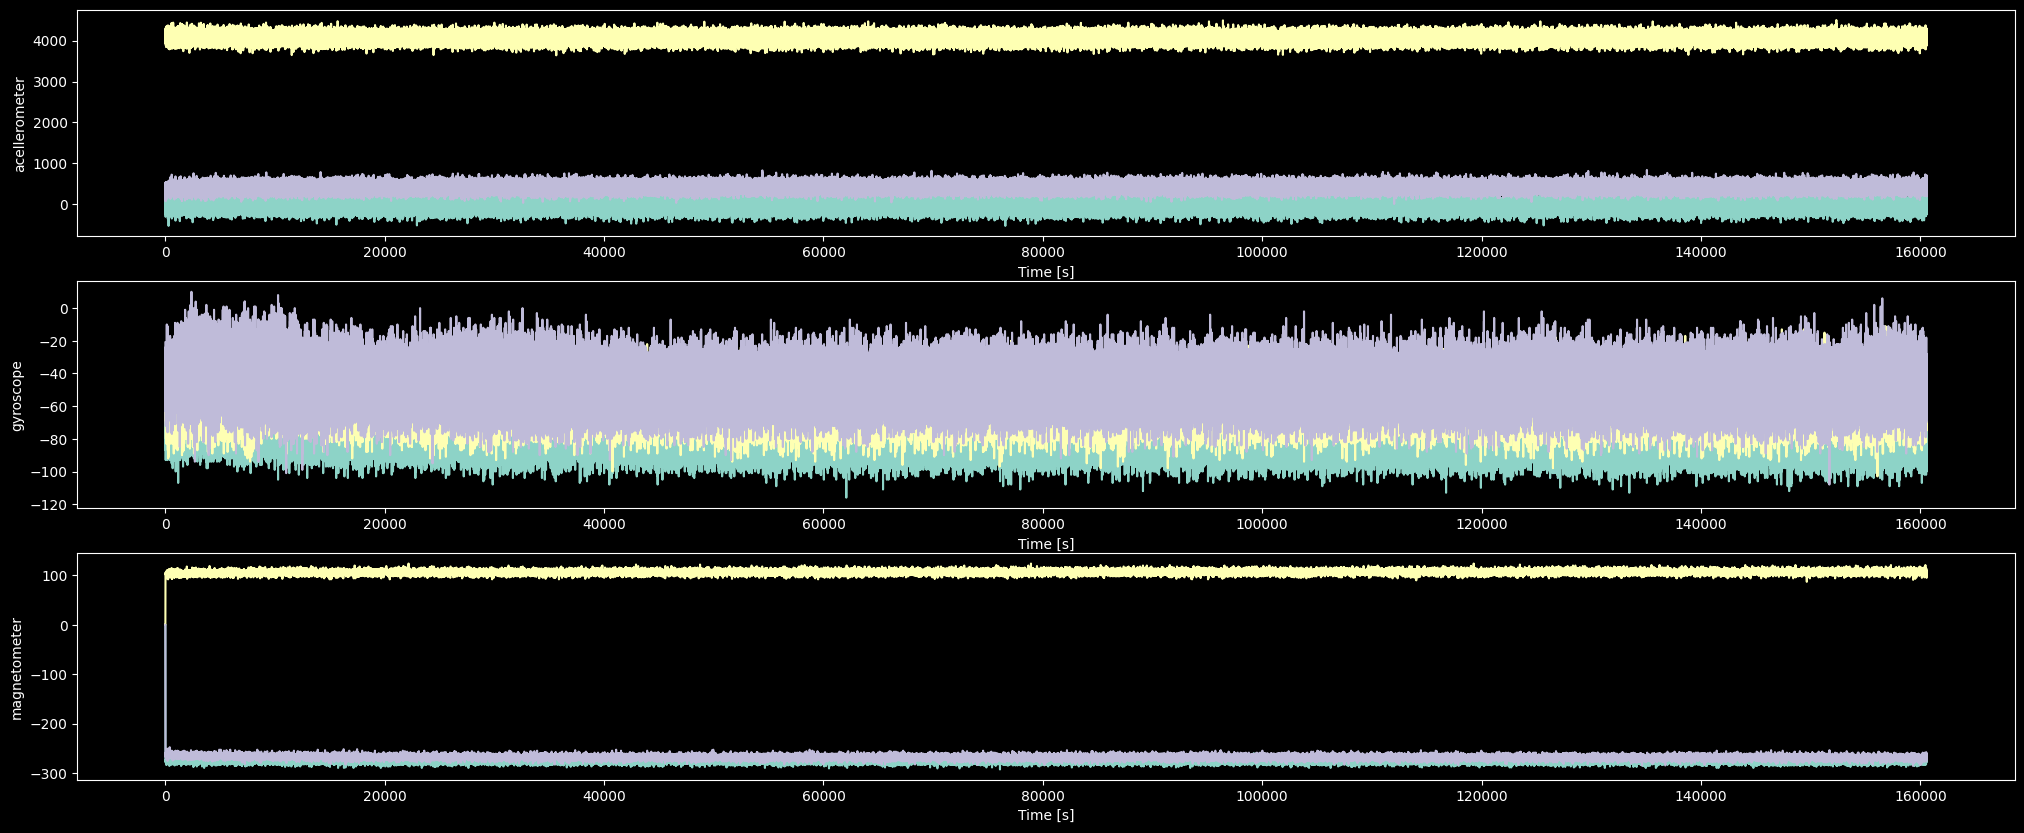

In [62]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25, 10))
# plt.rcParams['agg.path.chunksize'] = 10000  # Add this line if it does not rende


# For each array in the data
for i, arr in enumerate(accelerometer):
    # Plot the array with a label
    axes[0].plot(arr, label=f'acellerometer {i+1}')
    
# axes[0].set_ylim([-10, 370])
axes[0].set_ylabel("acellerometer")
axes[0].set_xlabel("Time [s]")

# For each array in the data
for i, arr in enumerate(gyroscope):
    # Plot the array with a label
    axes[1].plot(arr, label=f'gyroscope {i+1}')
    
# axes[1].set_ylim([-10, 370])
axes[1].set_ylabel("gyroscope")
axes[1].set_xlabel("Time [s]")

# For each array in the data
for i, arr in enumerate(magnetometer):
    # Plot the array with a label
    axes[2].plot(arr, label=f'magnetometer {i+1}')
    
# axes[2].set_ylim([-10, 370])
axes[2].set_ylabel("magnetometer")
axes[2].set_xlabel("Time [s]")

plt.show() 

In [ ]:
behavior.HarpRecording.Channel()